In [5]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
from pyforest import *
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
#from tf.keras.models import model_from_json

# define GPU id to use
# 0 = 1080 Bus ID 2
# 1 = Titan Bus ID 131
# 2 = Titan Bus ID 132
gpu_id = '0'
current_gpu = choose_gpu_by_id(gpu_id)

from src.utils.Utils_io import Console_and_file_logger, ensure_dir
from src.data.Dataset_utils import load_config
from src.data.Generators import DataGenerator

from src.data.Dataset import filter_x_by_patient_ids, get_img_msk_files_from_split_dir, get_patient, get_t_position_from_filename, get_z_position_from_filename
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.visualization.Visualize import show_2D_or_3D, plot_3d_vol, plot_4d_vol
import SimpleITK as sitk
from src.data.Dataset import describe_sitk, describe_volume, copy_meta_and_save, get_metadata_maybe
from src.data.Preprocess import from_channel_to_flat
from src.data.Postprocess import clean_3d_prediction_3d_cc
from albumentations import PadIfNeeded
import cv2
from skimage.transform import resize

#Console_and_file_logger('Evaluation', logging.INFO)
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Console_and_file_logger('prediction3D', logging.INFO)


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:191: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 2:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:203: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif img.ndim is 3:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:251: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 2:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:254: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 3:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:267: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 3:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:335: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if img.ndim is 2:
/mnt/ssd/git/3d-mri-domain-adaption/src/data/Preprocess.py:348: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif img.ndim is 3:
/mnt/ssd/git/3d-mri-dom

In [2]:
# load config
# load model
# define paths
# load dataframe and filter by fold and test-split
# extract patient ids of this test split
# load the filenames for all 2D slices for these patients (the trainings split consists just of the timesteps with a label (#5))
# sort dataframe by patient id, t and z
# predict per patient (filter, copy nrrd metadata, predict)
# create generator
# predict the volumes
# transform all numpy files into nrrd files
# copy all nrrd metadata (Spacing etc.) to the predicted files
# save nnrd files into a new path

In [6]:
# load files, create generator
@interact_manual
def predict4d_with_dataframe(fold=range(4),
                             c_file=sorted(glob.glob('reports/configs/2D/kfoldnewgcn_unsigned/gcn/**/**/*.json')),  
                             modality=['test','train', 'all'], 
                             df_path = 'data/raw/GCN_2nd/2D/df_kfold.csv',
                             pred_path = 'data/raw/peters/2D_unfiltered/all/',
                             export_path = 'data/interim/peters/temp/',
                             load_new=True,
                             filter_by_patientid=False):
    """
    Run model 4D prediction on a test modality of a fold within the kfold splitting dataframe or on all timesteps or on a directory
    Model is trained with 2D slices, the dataframe and path needs to contain 2D nrrd/dicom files
    :param c_file: Config file which defines tha model and parameters
    :param modality: evaluation modality, use this split (test/train/all)
    :param df_path: file path to the dataframe which should be used to define the splitting for this evaluation/model
    :param pred_path: path to 2D nrrd image/mask files which should be used for the prediction
                        1. if we want to predict all timesteps, but filter by the patient ids of the test split for the current model
                        2. if we want to predict all files of this directory (filter_by_patientid==False)
    :param load_new: reuse the current loaded model (used to increase the prediction performance), when we call this function in a loop
    :param filter_by_patientid: bool which tells if we want to filter the files from the pred path by the patient ids from the dataframe
    :return: None
    
    """
    # load config with all params into global namespace
    if load_new: # if we reuse a model and config, we dont need to reload/compile the model to save time
        glob_ = load_config(config_file_path=c_file, load=True)

        # update global namesspace to make config and model accesible
        globals().update(glob_)
        gcn_patients = config.get('GCN_PATIENTS', False)
        logging.info(gcn_patients)

    # print current config
    logging.info('Experiment: {}'.format(config['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
    # predict the segmentations for one patient
    config['SHUFFLE'] = False
    # no resample and augmentation
    config['RESAMPLE'] = False
    config['AUGMENT_GRID'] = False
    # make sure all files fit in batchsize
    config['BATCHSIZE'] = 1

    df = pd.read_csv(df_path)
    
    df = df[df['fold'] == fold]
    # get the subset with only the files from the test split
    df = df[df['modality'] == modality]

    # get all 2d slices, not only the masked one
    if pred_path:
        x,y = get_img_msk_files_from_split_dir(pred_path)
    else:
        # use the test split files from the dataframe to predict the masks
        logging.info('use the dataframe test split to predict the masks')
        x, y = df['x_path'].values, df['y_path'].values

    # get patient ids
    patients = list(df.patient.unique())

    # filter slices by patient ids of the current evaluation split
    df_prediction = filter_x_by_patient_ids(x=x, patient_ids=patients, modality='test', filter=filter_by_patientid)

    # if we did not filter the prediction files by the patient id of the dataframe, 
    # there is no need to equal number of patients
    if filter_by_patientid:
        # check if we have files for each patient of the test split
        assert len(df_prediction.patient.unique()) == len(patients)

    # get all patients ids
    # we need to use the patient ids from the df_predictions df instead of the patient list, to work with unfiltered paths
    for p in list(df_prediction.patient.unique()):

        logging.info('patient: {}'.format(p))
        
        # filter by patient
        df_patient = df_prediction[df_prediction['patient']==p].copy()
        
        # extract t and z for each patient, save the total shape of this 4D volume
        df_patient['t'] = df_patient['y_path'].apply(get_t_position_from_filename)
        df_patient['z'] = df_patient['y_path'].apply(get_z_position_from_filename)
        
        df_patient = df_patient.sort_values(by=['t','z'])
        t = df_patient['t'].nunique()
        z = df_patient['z'].nunique()
        print('t: {}'.format(t))
        print('z: {}'.format(z))
        
        test_generator = DataGenerator(df_patient['x_path'].values, df_patient['y_path'].values, config)
        
        volume = np.array([x for x,y in test_generator])
        volume = np.reshape(volume, (t, z,volume.shape[2], volume.shape[3]))
        
        gt = np.array([y for x,y in test_generator])
        gt = np.reshape(gt, (t, z,gt.shape[2], gt.shape[3], gt.shape[-1]))
        gt = gt  > 0.5
        globals()['gt']= gt
        # reduce the last channel
        gt = from_channel_to_flat(gt)
        # predict masks
        predictions = model.predict(test_generator, verbose=1)
        
         # convert to bool
        predictions = predictions >=0.5
        
        # reshape with t and z axis
        predictions = np.reshape(predictions, (t,z, *predictions.shape[1:]))
        
        # reduce the last channel
        predictions = from_channel_to_flat(predictions)
        
        # create n connected components per label and filter the biggest
        predictions = [clean_3d_prediction_3d_cc(pred) for pred in predictions]

        # need to join as series, otherwise sitk cant save 4d files
        new_mask = sitk.JoinSeries([sitk.GetImageFromArray(vol) for vol in predictions])
        new_volume = sitk.JoinSeries([sitk.GetImageFromArray(vol) for vol in volume])
        new_gt = sitk.JoinSeries([sitk.GetImageFromArray(vol) for vol in gt])

        # copy meta
        # get patient id
        p = df_patient.patient.unique()[0]

        # load 4d volume, to copy the right metadata
        # filter patient by the current patient identifier
        #file_4d = glob.glob('data/raw/GCN_2nd/4D/**/masks/{}*.nrrd'.format(p))[0]
        try:
            #file_4d = glob.glob('data/raw/ACDC/original/all/{}*4d.nii.gz'.format(p))[0]
            #file_4d = glob.glob('data/raw/GCN_2nd/4D/**/masks/{}*.nrrd'.format(p))[0]
            file_4d = glob.glob('data/raw/peters/4D/all/images/{}*nrrd'.format(p))[0]
            img = sitk.ReadImage(file_4d)
            describe_sitk(img)
        except Exception as e:
            img = None

        img = sitk.ReadImage(file_4d)
        describe_sitk(img)

        # copy metadata
        ensure_dir(export_path)

        copy_meta_and_save(new_mask, img, os.path.join(export_path, 'pred','{}__msk.nrrd'.format(p)))
        copy_meta_and_save(new_volume, img, os.path.join(export_path,'images',  '{}__img.nrrd'.format(p)))
        copy_meta_and_save(new_gt, img, os.path.join(export_path, 'gt', '{}__msk.nrrd'.format(p)))

        img = sitk.ReadImage(os.path.join(export_path, 'pred', '{}__msk.nrrd'.format(p)))
        describe_sitk(img)
        

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Dropdown(description='c_fil…

In [7]:
gt.shape

(30, 13, 224, 224, 4)

In [14]:
# load files, create generator
@interact_manual
def predict_3D_with_dataframe(fold=range(4),
                              c_file=sorted(glob.glob('reports/configs/2D/ax_sax/ax_baseline/**/**/*.json')),  
                              modality=['test','train', 'all'], 
                              df_path = 'data/raw/gcn_05_2020_ax_sax_86/folds.csv',
                              pred_path = 'data/raw/gcn_05_2020_ax_sax_86/AX_2D',
                              export_path = 'data/predicted/ax_on_ax_models/3D',
                              load_new=True,
                              filter_by_patientid=False):
    """
    
    
    Run model 3D prediction on: 
    a test modality of a fold within the kfold splitting dataframe 
    on all timesteps 
    or on a directory with 2D files
    Model is trained with 2D slices, the dataframe and path needs to contain 2D nrrd/dicom files
    The dataframe will be used to extract the patient ids of the test split of this model, 
    these ids will be used to filter the files from the pred path
    
    :param c_file: Config file which defines the model and parameters
    :param modality: evaluation modality, use this split (test/train/all)
    :param df_path: file path to the dataframe which should be used to define the splitting for this evaluation/model
    :param pred_path: path to 2D nrrd image/mask files which should be used for the prediction
                        1. if we want to predict all timesteps, but filter by the patient ids of the test split for the current model
                        2. if we want to predict all files of this directory (filter_by_patientid==False)
    :param load_new: reuse the current loaded model (used to increase the prediction performance), when we call this function in a loop
    :param filter_by_patientid: bool which tells if we want to filter the files from the pred path by the patient ids from the dataframe
    :return: None
    """
    
    # test with interativ filechooser
    #from ipyfilechooser import FileChooser
    #config_chooser = FileChooser(os.getcwd(), 'config.json')
    #display(config_chooser)
    #c_file  = config_chooser.selected
    try:
    
        # load config with all params into global namespace
        if load_new: # if we reuse a model and config, we dont need to reload/compile the model to save time
            glob_ = load_config(config_file_path=c_file, load=True)

            # update global namesspace to make config and model accesible
            globals().update(glob_)
            gcn_patients = config.get('GCN_PATIENTS', False)
            logging.info(gcn_patients)

        # print current config
        logging.info('Experiment: {}'.format(config['EXPERIMENT']))
        logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))

        # predict the segmentations for one patient
        config['SHUFFLE'] = False
        # no resample and augmentation
        config['RESAMPLE'] = False
        config['AUGMENT_GRID'] = False
        # make sure all files fit in batchsize
        config['BATCHSIZE'] = 1

        df = pd.read_csv(df_path)

        df = df[df['fold'] == fold]
        # get the subset with only the files from the test split
        df = df[df['modality'] == modality]

        # get patient ids
        patients = list(df.patient.unique())
        globals()['df'] = df

        # get all 2d slices, not only the masked one
        if pred_path:
            #x = sorted(glob.glob(os.path.join(pred_path, '*img.nrrd')))
            #y = sorted(glob.glob(os.path.join(pred_path, '*msk.nrrd')))
            x,y = get_img_msk_files_from_split_dir(pred_path)

        else:
            # use the test split files from the dataframe to predict the masks
            logging.debug('use the dataframe test split to predict the masks')
            x, y = df['x_path'].values, df['y_path'].values

        # filter slices by patient ids of the current evaluation split
        df_prediction = filter_x_by_patient_ids(x=x, patient_ids=patients, modality='test', filter=filter_by_patientid)
        logging.info(df_prediction.shape)
        globals()['df'] = df_prediction

        # if we did not filter the prediction files by the patient id of the dataframe, 
        # there is no need to equal number of patients
        if filter_by_patientid:
            # check if we have files for each patient of the test split
            assert len(df_prediction.patient.unique()) == len(patients)


        # get all patients ids
        for p in list(df_prediction.patient.unique()):

            # filter slices by patient ids of the current evaluation split
            df_patient = df_prediction[df_prediction['patient']==p].copy()

            # extract t and z for each patient, save the total shape of this 4D volume
            df_patient['t'] = df_patient['y_path'].apply(get_t_position_from_filename)
            df_patient['z'] = df_patient['y_path'].apply(get_z_position_from_filename)

            df_patient = df_patient.sort_values(by=['t','z'])
            t = df_patient['t'].nunique()
            z = df_patient['z'].nunique()
            logging.info('Patient: {}, with t: {}, z: {}'.format(p, t, z))

            for timestep in df_patient['t'].unique():
                logging.info(timestep)
                #logging.info(df_patient['t'])

                df_patient_t = df_patient[df_patient['t'] == timestep].copy()
                logging.info(df_patient_t.shape)

                test_generator = DataGenerator(df_patient_t['x_path'].values, df_patient_t['y_path'].values, config)

                volume = np.array([x for x,y in test_generator])
                volume = np.reshape(volume, (z,volume.shape[2], volume.shape[3]))
                gt = np.array([y for x,y in test_generator])
                gt = np.reshape(gt, (z,gt.shape[2], gt.shape[3], gt.shape[-1]))
                gt = gt >= 0.5
                # reduce the last channel
                gt = from_channel_to_flat(gt)

                # predict masks
                predictions = model.predict(test_generator, verbose=1)

                 # convert to bool
                predictions = predictions >= 0.5

                # reduce the last channel
                predictions = from_channel_to_flat(predictions)

                # create n connected components per label and keep only the biggest
                pred = clean_3d_prediction_3d_cc(predictions)

                # Load orig 4D image and copy meta
                # get patient id
                p = df_patient.patient.unique()[0]
                logging.info(p)


                # load 4d volume, to copy the right metadata
                #file_4d = glob.glob('data/raw/GCN_2nd/4D/**/masks/{}*.nrrd'.format(p))[0]
                try:
                    #file_4d = glob.glob('data/raw/ACDC/original/all/**/{}*4d.nii.gz'.format(p))[0]
                    #file_4d = glob.glob('data/raw/gcn_05_2020/SAx_4D/{}*.nrrd'.format(p))[0]
                    #file_4d = glob.glob('data/interim/sax_ax_3d_thres_50_max/ax_to_sax/{}*.nrrd'.format(p))[0]
                    #file_4d = glob.glob('data/raw/GCN/4D/**/images/{}*.nrrd'.format(p))[0]
                    #file_4d = glob.glob('data/raw/peters/4D/all/images/{}*nrrd'.format(p))[0]
                    file_4d = glob.glob('data/raw/gcn_05_2020_ax_sax_86/AX/{}*clean.nrrd'.format(p))[0]
                    img = sitk.ReadImage(file_4d)
                    describe_sitk(img)
                except Exception as e:
                    logging.error('no metadata and spacing copied: {}'.format(str(e)))
                    img = None

                # undo generator cropping and resizing
                orig_sitk = sitk.ReadImage(file_4d)
                orig_size = sitk.GetArrayFromImage(orig_sitk).shape
                size = pred.shape

                min_o_size = min(orig_size[-1], orig_size[-2])
                predictions = list()
                gts = list()
                images = list()

                # if pred size bigger than orig_size --> resize to square
                if size[-1] > min_o_size and size[-2] > min_o_size:
                    logging.info('resize')
                    for i in range(pred.shape[0]):
                        predictions.append(
                            resize(pred[i,...], (min_o_size,min_o_size), mode='constant', anti_aliasing=False, preserve_range=True, order=0, cval=0,
                                   clip=True).astype(pred.dtype))
                        gts.append(
                            resize(gt[i,...], (min_o_size,min_o_size), mode='constant', anti_aliasing=False, preserve_range=True, order=0, cval=0,
                                   clip=True).astype(gt.dtype))
                        images.append(
                            resize(volume[i,...], (min_o_size,min_o_size), mode='constant', anti_aliasing=True, preserve_range=True, order=1, clip=True))

                    volume = np.stack(images, axis=0)
                    pred = np.stack(predictions, axis=0)
                    gt = np.stack(gts, axis=0)

                logging.info('predictions size after resize: {}'.format(pred.shape))

                predictions = list()
                gts = list()
                images = list()
                # pad with zeros
                pad = PadIfNeeded(min_height=orig_size[-2], min_width=orig_size[-1], border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0,p=1, always_apply=True)
                # pad if needed, for smaller images or if orig is not square
                for i in range(pred.shape[0]):
                    predictions.append(pad(image=pred[i,...])['image'])
                    gts.append(pad(image=gt[i,...])['image'])
                    images.append(pad(image=volume[i,...])['image'])
                pred = np.stack(predictions, axis=0)
                gt = np.stack(gts, axis=0)
                volume = np.stack(images, axis=0)
                logging.info('predictions size after pad: {}'.format(pred.shape))

                # create a sitk image from the numpy files
                new_mask = sitk.GetImageFromArray(pred)
                new_volume = sitk.GetImageFromArray(volume)
                new_gt = sitk.GetImageFromArray(gt)

                orig_sitk = sitk.ReadImage(file_4d)
                orig_size = orig_sitk.GetSize()
                size = new_volume.GetSize()

                # debug
                #globals()['pred'] = predictions
                #globals()['gt'] = gt
                #globals()['orig'] = orig_sitk

                logging.info('orig size: {}'.format(orig_size))
                logging.info('pred size: {}'.format(size))

                # copy metadata
                ensure_dir(export_path)

                copy_meta_and_save(new_mask, img, os.path.join(export_path, 'pred', '{}_{}_msk.nrrd'.format(p, timestep)))
                copy_meta_and_save(new_volume, img, os.path.join(export_path, 'images', '{}_{}_img.nrrd'.format(p, timestep)))
                copy_meta_and_save(new_gt, img, os.path.join(export_path, 'gt', '{}_{}_msk.nrrd'.format(p, timestep)))
                # proof if the predictions exists
                img = sitk.ReadImage(os.path.join(export_path, 'pred', '{}_{}_msk.nrrd'.format(p, timestep)))
                describe_sitk(img)
    except Exception as e:
        logging.error('Exception {} with {}'.format(str(e), locals()['df_patient']))
        raise e
        

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Dropdown(description='c_fil…

# predict 3D volumes from 3D dataframe and 3D files

In [2]:
# load files, create generator
@interact_manual
def predict_3D_with_dataframe(FOLD=range(4),
                              c_file=sorted(glob.glob('reports/configs/3D/ax_sax/st_unet_ax_and_sax/temp/2020-07-03_13_01/*.json')),  
                              modality=['test','train', 'all'], 
                              df_path = 'data/raw/gcn_05_2020_ax_sax_86/folds.csv',
                              PRED_PATH = 'data/raw/gcn_05_2020_ax_sax_86/AX_3D_ISO',
                              export_path = 'data/predicted/joint_AX_SAX_training/3D/',
                              load_new=True,
                              filter_by_patientid=False):
    """
    
    
    Run model 3D prediction on a test modality of a fold within the kfold splitting dataframe or on all timesteps or on a directory
    Model is trained with 2D slices, the dataframe and path needs to contain 2D nrrd/dicom files
    The dataframe will be used to extract the patient ids of the test split of this model, 
    these ids will be used to filter the files from the pred path
    
    :param c_file: Config file which defines tha model and parameters
    :param modality: evaluation modality, use this split (test/train/all)
    :param df_path: file path to the dataframe which should be used to define the splitting for this evaluation/model
    :param pred_path: path to 2D nrrd image/mask files which should be used for the prediction
                        1. if we want to predict all timesteps, but filter by the patient ids of the test split for the current model
                        2. if we want to predict all files of this directory (filter_by_patientid==False)
    :param load_new: reuse the current loaded model (used to increase the prediction performance), when we call this function in a loop
    :param filter_by_patientid: bool which tells if we want to filter the files from the pred path by the patient ids from the dataframe
    :return: None
    """
    
    # load config with all params into global namespace
    if load_new: # if we reuse a model and config, we dont need to reload/compile the model to save time
        glob_ = load_config(config_file_path=c_file, load=True)

        # update global namesspace to make config and model accesible
        globals().update(glob_)
        gcn_patients = config.get('GCN_PATIENTS', False)
        logging.info(gcn_patients)

    # print current config
    logging.info('Experiment: {}'.format(config['EXPERIMENT']))
    #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
    # predict the segmentations for one patient
    config['SHUFFLE'] = False
    # no resample and augmentation
    config['RESAMPLE'] = True
    config['AUGMENT_GRID'] = False
    # make sure all files fit in batchsize
    config['BATCHSIZE'] = 1
    
    
    x_train, y_train, x_val, y_val =  get_trainings_files(data_path=PRED_PATH,fold=FOLD)
    logging.info('x_val files: {}, y_val files: {}'.format(len(x_val), len(y_val)))

    # get all patients ids
    for img_f, msk_f in zip(x_val, y_val):
        
        file_short = os.path.basename(os.path.normpath(img_f))
        
        test_generator = DataGenerator([img_f], [msk_f], config)

        volume = np.squeeze(np.array([x for x,y in test_generator]))
        logging.info(volume.shape)
        gt = np.squeeze(np.array([y for x,y in test_generator]))
        logging.info('pred on: {}'.format(volume.shape))

        gt = gt >= 0.5
        # reduce the last channel
        gt = from_channel_to_flat(gt)

        # predict masks
        predictions = model.predict(test_generator, verbose=1)
        predictions = predictions >= 0.5

        # reduce the last channel
        predictions = from_channel_to_flat(predictions)

        # create n connected components per label and keep only the biggest
        predictions = clean_3d_prediction_3d_cc(predictions[0])
        logging.info('filtered pred: {}'.format(predictions.shape))
        show_2D_or_3D(volume[::4], predictions[::4])
        plt.show()

        # create a sitk image from the numpy files
        new_mask = sitk.GetImageFromArray(predictions)
        new_volume = sitk.GetImageFromArray(volume)
        new_gt = sitk.GetImageFromArray(gt)

        # copy meta
        # get patient id
        from src.data.Dataset import get_patient
        p = get_patient(file_short)
        logging.info('patient: {}'.format(p))

        try:
            reference_file = glob.glob(os.path.join(PRED_PATH,'{}*.nrrd'.format(p)))[0]
            img = sitk.ReadImage(reference_file)
            describe_sitk(img)
        except Exception as e:
            logging.error('no metadata and spacing copied: {}'.format(str(e)))
            img = None

        # copy metadata
        ensure_dir(export_path)
        generator_spacing = list(reversed(config['SPACING']))

        copy_meta_and_save(new_mask, img, os.path.join(export_path, 'pred', file_short.replace('img','msk')), override_spacing=generator_spacing)
        copy_meta_and_save(new_volume, img, os.path.join(export_path, 'images', file_short), override_spacing=generator_spacing)
        copy_meta_and_save(new_gt, img, os.path.join(export_path, 'gt', file_short.replace('img','msk')), override_spacing=generator_spacing)

        img = sitk.ReadImage(os.path.join(export_path, 'pred', file_short.replace('img','msk')))
        describe_sitk(img)


interactive(children=(Dropdown(description='FOLD', options=(0, 1, 2, 3), value=0), Dropdown(description='c_fil…

1. Define a path to 3D images and masks
    1. Additionaly define a path to a dataframe with folds and patient IDs
2. Define a Path to a config
3. Load the model, create a datagenerator
4. Predict labels, copy metadata from the raw 3D file
5. reconstruct the original volume size if it was changed by the generator

In [2]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json',title='select a config')
display(config_chooser)
df_chooser = FileChooser(os.path.join(os.getcwd(),'data/raw'), '', title='select a dataframe')
display(df_chooser)
predict_path_chooser = FileChooser(os.path.join(os.getcwd(),'data/raw'), '', title='select a folder with images/masks')
display(predict_path_chooser)
predictions = list()
# load files, create generator
@interact_manual
def predict_3D_with_dataframe(fold=range(4),
                              export_path = 'data/predicted/AX_to_SAX_ISO_with_SAX_wrapper/',
                              filter_by_patientid=False):
    """
    
    
    Run model 3D prediction on on a directory
    Model is trained with 2D slices and packed in a 3D wrapper
    The dataframe could be used to filter the testset of one fold
    
    :param c_file: Config file which defines tha model and parameters
    :param modality: evaluation modality, use this split (test/train/all)
    :param df_path: file path to the dataframe which should be used to define the splitting for this evaluation/model
    :param pred_path: path to 2D nrrd image/mask files which should be used for the prediction
                        1. if we want to predict all timesteps, but filter by the patient ids of the test split for the current model
                        2. if we want to predict all files of this directory (filter_by_patientid==False)
    :param load_new: reuse the current loaded model (used to increase the prediction performance), when we call this function in a loop
    :param filter_by_patientid: bool which tells if we want to filter the files from the pred path by the patient ids from the dataframe
    :return: None
    """
    
    c_file=config_chooser.selected
    df_path = df_chooser.selected
    pred_path = predict_path_chooser.selected
    image_suffix = '*img.nrrd'
    mask_suffix = '*msk.nrrd'
    #image_suffix = '**/*frame[0-9][0-9].nii.gz'
    #mask_suffix = '**/*frame*_gt.nii.gz'

    
    # load config with all params into global namespace
    assert c_file is not None,'No config selected'
    glob_ = load_config(config_file_path=c_file, load=True)
    # update global namesspace to make config and model accesible
    globals().update(glob_)
    logging.info('Experiment: {}'.format(config['EXPERIMENT']))
    # predict the segmentations for one patient
    config['SHUFFLE'] = False
    # no resample and augmentation
    config['RESAMPLE'] = False
    config['AUGMENT_GRID'] = False
    config['AUGMENT'] = False
    # make sure all files fit in batchsize
    config['BATCHSIZE'] = 1
        
    images = None
    
    if df_path and pred_path and filter_by_patientid == True:
        from src.data.Dataset import get_trainings_files
        _, _, images, masks =  get_trainings_files(data_path=pred_path,fold=fold, path_to_folds_df=df_path)
    elif pred_path:
        # load image/masks
        images = sorted(glob.glob(os.path.join(pred_path, image_suffix)))
        masks = sorted(glob.glob(os.path.join(pred_path, mask_suffix)))
        
    assert images, 'no files for the prediction found'
    
    if len(masks) == 0:
        masks = None
    generator = DataGenerator(images,masks,config)

    # predict each image in a loop to avoid loading all volumes into the memory
    for batch, f_name in zip(generator, images):
        img, gt = batch
        path, filename = os.path.split(f_name)
        logging.info('predict: {}'.format(filename))
        # predict the masks
        pred = model.predict(x=[img])
        
        predictions.append(pred)
         # convert to bool
        pred = np.squeeze(pred) >= 0.5
        gt = np.squeeze(gt) >= 0.5
        # reduce the last channel
        pred = from_channel_to_flat(pred)
        gt = from_channel_to_flat(gt)
        # filter by the bigest connected component per label
        pred = clean_3d_prediction_3d_cc(pred)
        
        # open sitk image and copy meta
        sitk_img = sitk.ReadImage(f_name)
        
        # create sitk images
        pred = sitk.GetImageFromArray(pred)
        img = sitk.GetImageFromArray(np.squeeze(img))
        gt = sitk.GetImageFromArray(gt)
        
        ensure_dir(export_path)
        copy_meta_and_save(pred, sitk_img, os.path.join(export_path, '3D', 'pred', filename.replace('img','msk')))
        copy_meta_and_save(img, sitk_img, os.path.join(export_path, '3D', 'images', filename))
        copy_meta_and_save(gt, sitk_img, os.path.join(export_path, '3D', 'gt', filename.replace('img','msk')))
        # validate prediction
        #img = sitk.ReadImage(os.path.join(export_path, 'pred', filename))
        #describe_sitk(img)
        

FileChooser(path='/mnt/data/git/cardio/reports/configs', filename='config.json', show_hidden='False')

FileChooser(path='/mnt/data/git/cardio/data/raw', filename='', show_hidden='False')

FileChooser(path='/mnt/data/git/cardio/data/raw', filename='', show_hidden='False')

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3), value=0), Text(value='data/predicted/…

In [4]:
len(predictions)

7

(80, 224, 224, 4)


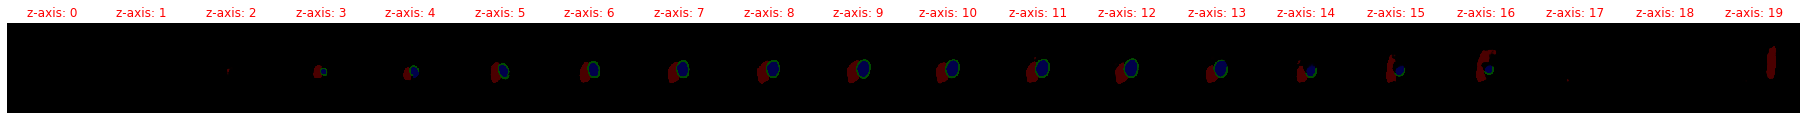

In [15]:
temp = predictions[0][0].copy()
print(temp.shape)
show_2D_or_3D(temp)

(80, 224, 224, 4)


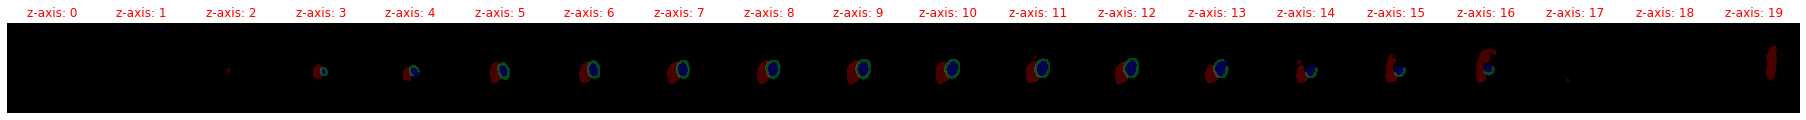

In [16]:
# diletation
kernel = np.ones((3,3),np.uint8)
dile = np.stack([cv2.dilate(img,kernel,iterations = 1) for img in temp],axis=0)
print(dile.shape)
show_2D_or_3D(dile)

(80, 224, 224, 4)


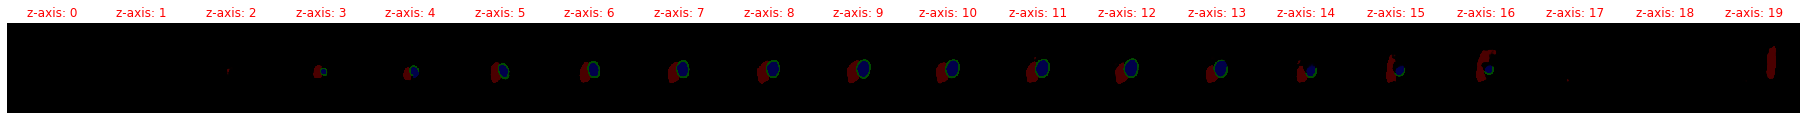

In [17]:
# closing
kernel = np.ones((3,3),np.uint8)
clos = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in temp],axis=0)
print(clos.shape)
show_2D_or_3D(clos)

(80, 224, 224, 4)


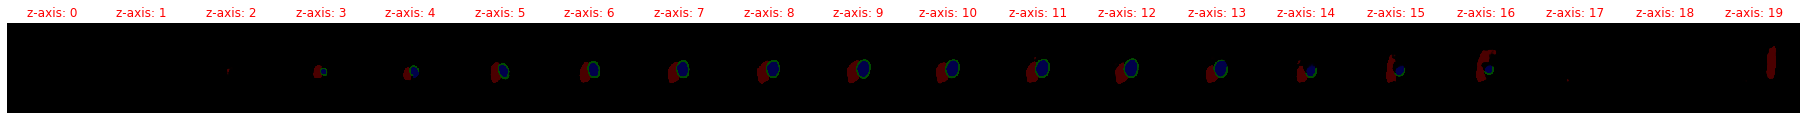

In [18]:
# closing followed diletation
kernel = np.ones((3,3),np.uint8)
dile = np.stack([cv2.dilate(img,kernel,iterations = 1) for img in temp],axis=0)
clos = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in temp],axis=0)
print(clos.shape)
show_2D_or_3D(clos)


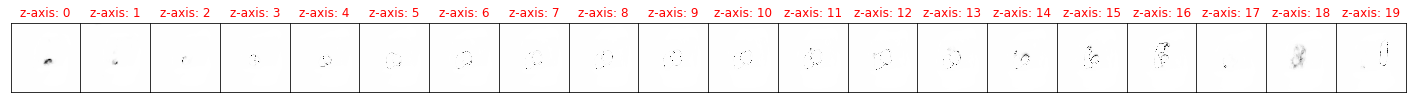

In [59]:

temp_max = tf.reduce_max(temp[0][...,:],axis=-1).numpy()
show_2D_or_3D(temp_max)
plt.show()


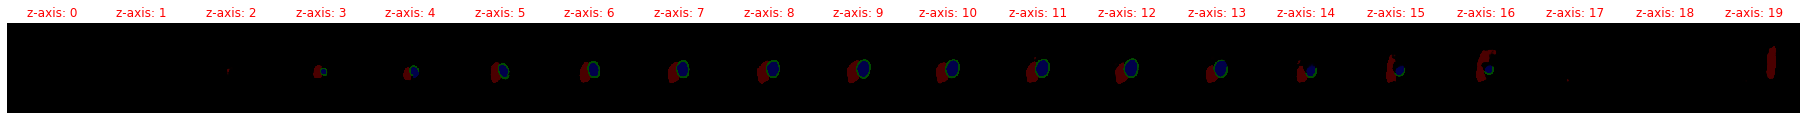

In [8]:
show_2D_or_3D(temp[0])

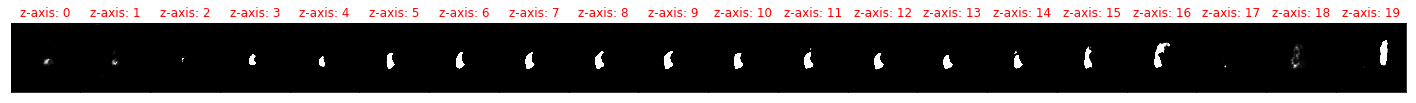

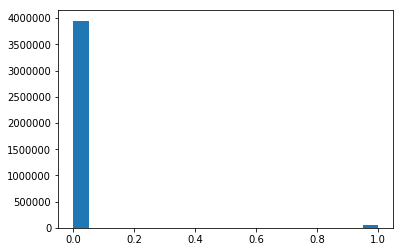

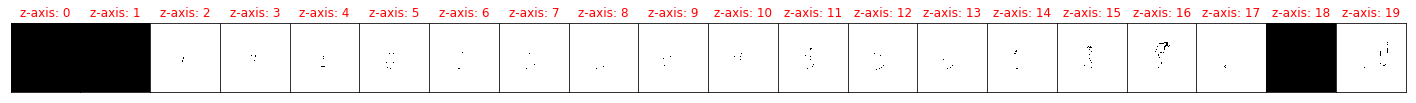

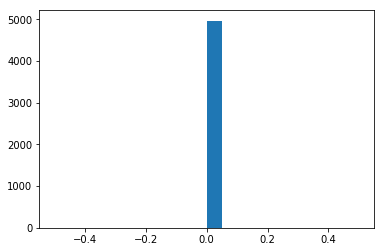

In [52]:
back = temp[0][...,1].copy()
show_2D_or_3D(back);plt.show()
_ =plt.hist(back.flatten(), bins=20);plt.show()

back[np.logical_or(back<0.1, back>0.9)] = 1
back[np.logical_or(back<1, back==0)] = 0

show_2D_or_3D(back);plt.show()
_ =plt.hist(back[back<1].flatten(),bins = 20)

In [38]:
np.logical_or(rv<0.1, rv>0.8).sum()

4009946

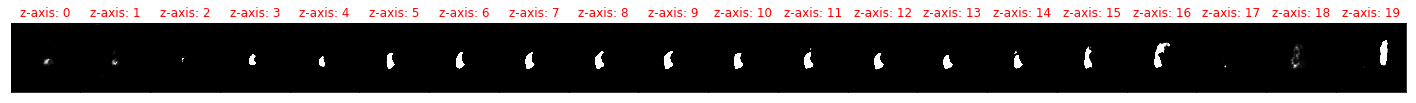

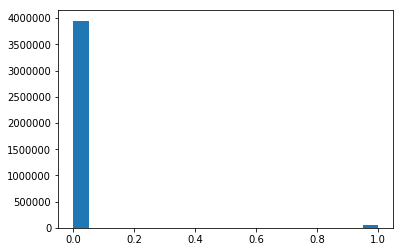

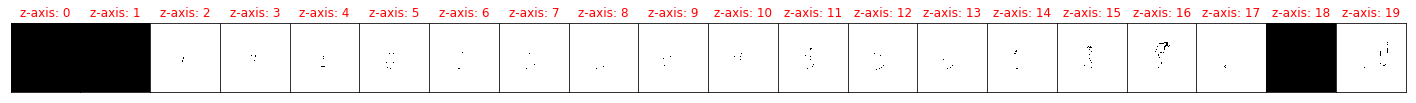

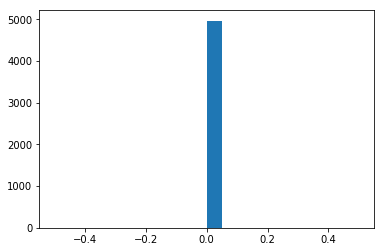

In [49]:
rv = temp[0][...,1].copy()
show_2D_or_3D(rv);plt.show()
_ =plt.hist(rv.flatten(), bins=20);plt.show()

rv[np.logical_or(rv<0.1, rv>0.9)] = 1
rv[np.logical_or(rv<1, rv==0)] = 0

show_2D_or_3D(rv);plt.show()
_ =plt.hist(rv[rv<1].flatten(),bins = 20)


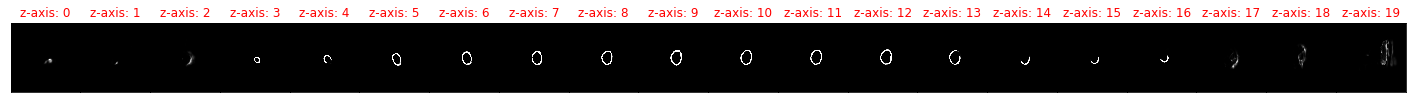

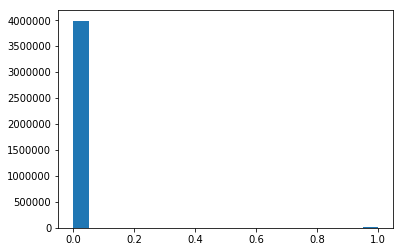

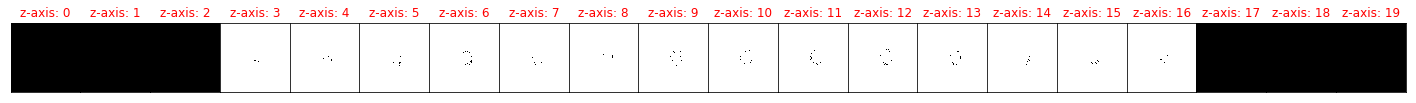

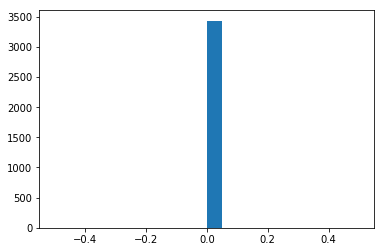

In [50]:
myo = temp[0][...,2].copy()
show_2D_or_3D(myo);plt.show()
_ =plt.hist(myo.flatten(), bins=20);plt.show()

myo[np.logical_or(myo<0.1, myo>0.9)] = 1
myo[np.logical_or(myo<1, myo==0)] = 0

show_2D_or_3D(myo);plt.show()
_ =plt.hist(myo[myo<1].flatten(),bins = 20)

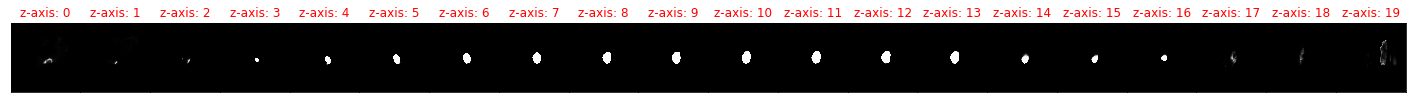

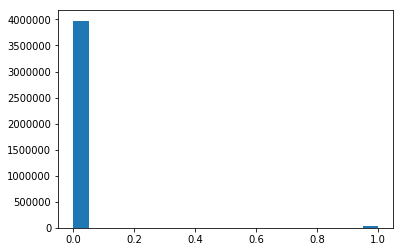

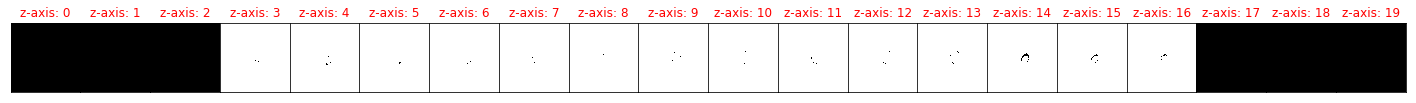

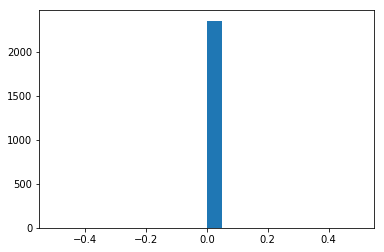

In [51]:
lv = temp[0][...,3].copy()
show_2D_or_3D(lv);plt.show()
_ =plt.hist(lv.flatten(), bins=20);plt.show()

lv[np.logical_or(lv<0.1, lv>0.9)] = 1
lv[np.logical_or(lv<1, lv==0)] = 0

show_2D_or_3D(lv);plt.show()
_ =plt.hist(lv[lv<1].flatten(),bins = 20)